In [3]:
@autht

UsageError: Missing module name.


# Import Graph Tool Modules
    Specifically graph_tool main, draw and collection modules

In [16]:
import graph_tool.all
import graph_tool as gt
import graph_tool.draw
import graph_tool.collection

# Import Other Required Modules
    These Modules include Matplotlib

In [17]:
import matplotlib as mpl

In [30]:
%matplotlib inline

# View Graph Tool Collection

In [33]:
list(gt.collection.data.keys())

['hep-th',
 'netscience',
 'polblogs',
 'celegansneural',
 'power',
 'email-Enron',
 'adjnoun',
 'cond-mat',
 'lesmis',
 'serengeti-foodweb',
 'astro-ph',
 'pgp-strong-2009',
 'polbooks',
 'as-22july06',
 'cond-mat-2005',
 'cond-mat-2003',
 'karate',
 'dolphins',
 'football']

# Sample Graph Generation

In [34]:
graph = gt.collection.data["football"]

In [35]:
#plt.switch_backend("cairo")

In [36]:
#plt.figure(figsize=(10,10))

In [37]:
pos = gt.draw.sfdp_layout(graph)

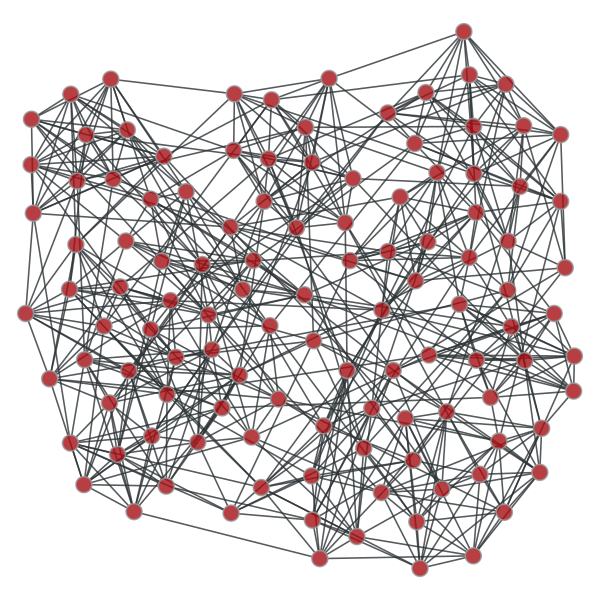

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f42f9f71828, at 0x7f42f9f7d978>

In [38]:
gt.draw.graph_draw(graph, pos=pos)

In [ ]:
gt.